In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-dogs-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "XueCHN/ddpm-dogs-128"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [17]:
from datasets import load_dataset

config.dataset_name = "huggan/few-shot-dog"
dataset = load_dataset(config.dataset_name, split="train")

d:\Anaconda3\envs\d2l\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


C:\Users\24577\AppData\Local\Temp\ipykernel_5756\3278871621.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


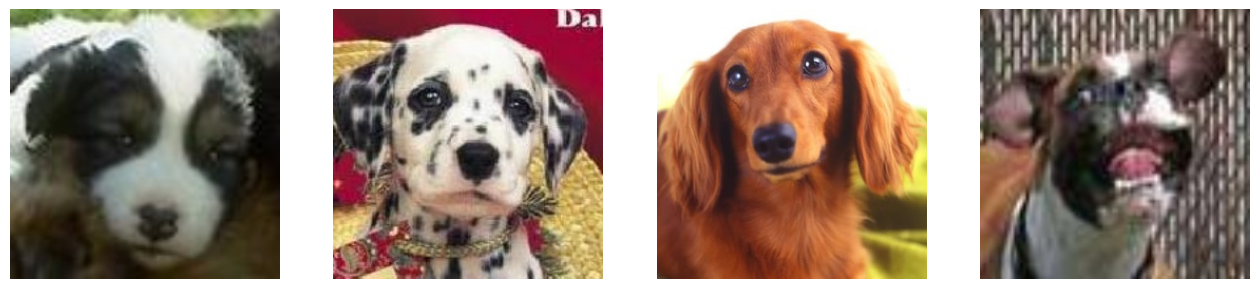

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [19]:
#preprocess the dataset
#Resize changes the image size to the one defined in config.image_size.
#RandomHorizontalFlip augments the dataset by randomly mirroring the images.
#Normalize is important to rescale the pixel values into a [-1, 1] range, 
# which is what the model expects.
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images=[preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [22]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [24]:
from diffusers import UNet2DModel

model=UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",    
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [26]:
#quickly check the sample image shape matches the model output shape
sample_image=dataset[0]["images"].unsqueeze(0)
print("input shape: ", sample_image.shape)

print("output shape: ", model(sample_image,timestep=0).sample.shape)


input shape:  torch.Size([1, 3, 128, 128])
output shape:  torch.Size([1, 3, 128, 128])


In [1]:
# create a scheduler
#During inference, the scheduler generates image from the noise. 
# During training, the scheduler takes a model output - or a sample 
# - from a specific point in the diffusion process and applies noise 
# to the image according to a noise schedule and an update rule.

#use DDPMscheduler and use the add_noise method to add some random noise to
# the sample_image before:
import torch
from PIL import Image
from diffusers import DDPMscheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0,2,3,1)+1.0)*127.5).type(torch.uint8).numpy()[0])

In [ ]:
#The training objective of the model is to predict the noise added to the image. 
#calculate the loss at this step
import torch.nn.functional as F

noise_pred=model(noisy_image, timesteps).sample
loss=F.mse_loss(noise_pred, noise)

In [ ]:
#optimizer and learning rate scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler=get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=config.lr_warmup_steps,num_training_steps=(len(train_dataloader)*config.num_epochs),)

#For evaluation, use the DDPMPipeline to generate 
# a batch of sample images and save it as a grid
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    #sample image from random noise
    #default pipeline output type is 'List[PIL.Image]'
    images=pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
    ).images
    #make a grid out of the images
    image_grid=make_image_grid(images,rows=4,cols=4)
    #save the images
    test_dir=os.path.join(config.output_dir,"samples")
    os.makedirs(test_dir,exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [3]:
#wrap all these components together in a training loop with 
# huggingface Accelerate for easy TensorBoard logging, 
# gradient accumulation, and mixed precision training
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm import tqdm
from pathlib import Path

def train_loop(config,model,noise_scheduler,optimizer,train_dataloader,lr_scheduler):
    #initialize accelerator and tensorboard logging
    accelerator=Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    #Prepare train
    #unpack the objects in the same order that gave them to the prepare method
    model,optimizer,train_dataloader,lr_scheduler=accelerator.prepare(
        model,optimizer,train_dataloader,lr_scheduler
    )
    global_step=0
    
    #now train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_image=batch["images"]
            #add noise to the image
            noise=torch.randn(clean_image.shape,device=clean_image.device)
            bs=clean_image.shape[0]
            
            #sample a random timestep for each image
            timesteps=torch.randint(0,noise_scheduler.config.num_train_timesteps,(bs,),device=clean_image.device, dtype=torch.int64)
            
            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images=noise_scheduler.add_noise(clean_image,noise,timesteps)
            
            with accelerator.accumulate(model):
                #predict the noise residual
                noise_pred=model(noisy_images,timesteps,return_dict=False)[0]
                loss=F.mse_loss(noise_pred,noise)
                accelerator.backward(loss)
                
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs={"loss":loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0],"step":global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step+=1
        
        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline=DDPMPipeline(unet=accelerator.unwrap_model(model),scheduler=noise_scheduler)
            if (epoch+1)%config.save_image_epochs==0 or epoch == config.num_epochs - 1:
                evaluate(config,epoch,pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

SyntaxError: unexpected EOF while parsing (3375539524.py, line 51)

In [ ]:
#Pass the function the training loop, all the training arguments, 
# and the number of processes to use for training
from accelerate import notebook_launcher
import glob

args=(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

sample_images=sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])